In [69]:
import pandas as pd
import numpy as np
import copy, time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder

df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_features.csv')

train_Y = df_train['poi']
train_Y = train_Y.astype(int)
train_num = train_Y.shape[0]



names = df_test['name']
df_train = df_train.drop(['name', 'poi'] , axis=1)
df_test = df_test.drop(['name'] , axis=1)
df = pd.concat([df_train,df_test])
df.reset_index(drop=True, inplace=True)
#df=df_train


In [70]:
def normalize_value(x):
    x = (( (x - min(x)) / ( max(x) - min(x) ) ) - 0.5) * 2
    return x

#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]

#試一些不同填補缺值的方式（D12），搭配標準化
# 空值補 0
#'salary', 'other'，空值用平均值
for feature in num_features:
    if feature=='salary' or feature=='other':
        df[feature] = df[feature].fillna(df[feature].mean())
    else:
        df[feature] = df[feature].fillna(0)
    df[feature] = normalize_value(df[feature])


    

df_train=df[:train_num]
df_test=df[train_num:]

df

19 Numeric Features : ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']



,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,-0.964045,-0.993631,0.749623,-1.0,-0.873018,-0.982064,-0.997494,-0.840909,-0.986864,-1.0,-0.933349,-0.991805,-0.919462,-0.342095,-0.968532,-0.687013,-0.880520,-0.996740,-0.896047
1,-0.884944,-0.993631,1.000000,-1.0,-0.876509,-0.988793,-0.984967,-0.666667,-0.901478,-1.0,-0.920861,-0.998963,-0.857844,-0.342095,-0.916807,-0.260279,-0.521157,-0.943962,-0.879703
2,-0.995891,-0.993631,0.999702,-1.0,-0.989579,-0.991258,-0.994571,-0.950758,-0.954023,-1.0,-1.000000,-0.926252,-0.947735,-0.342095,-0.984169,-0.967035,-0.970295,-0.987067,-0.988320
3,-0.983563,-0.993631,1.000000,-1.0,-1.000000,-0.954869,-1.000000,-1.000000,-1.000000,-1.0,-0.975159,-0.957462,-0.945992,-0.342095,-0.983236,-1.000000,-1.000000,-0.982880,-0.995264
4,-0.974318,-0.993631,0.981245,-1.0,-1.000000,-0.986316,-0.979955,-0.246212,-0.917898,-1.0,-0.984531,-0.999977,-0.958917,-0.342095,-0.982047,-0.207390,-0.657007,-0.989420,-0.999217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,-0.979454,-0.993631,1.000000,-1.0,-0.990597,-0.985269,-0.994432,-0.912879,-0.973727,-1.0,-0.984761,-0.980046,-0.955125,-0.342095,-0.984036,-0.516030,-0.787841,-0.986785,-0.991311
142,-0.969181,-0.993631,1.000000,-1.0,-0.988225,-1.000000,-0.987194,-0.893939,-0.924466,-1.0,-0.977148,-0.913181,-0.941352,-0.342095,-0.967922,-0.238181,-0.579246,-0.972020,-0.985396
143,-1.000000,-0.962275,1.000000,-1.0,-0.985770,-1.000000,-0.998330,-1.000000,-1.000000,-1.0,-0.980961,-0.956920,-0.960813,-0.342095,-0.957930,-0.991668,-0.977688,-0.993762,-0.989588
144,-0.995891,-0.980950,1.000000,-1.0,-0.983646,-0.977947,-1.000000,-1.000000,-1.000000,-1.0,-0.992787,-0.999877,-0.953067,-0.342095,-0.982326,-1.000000,-1.000000,-0.994347,-0.985694


In [71]:
df.isnull().sum().sort_values(ascending=False)
df.dtypes

bonus                        float64
deferral_payments            float64
deferred_income              float64
director_fees                float64
exercised_stock_options      float64
expenses                     float64
from_messages                float64
from_poi_to_this_person      float64
from_this_person_to_poi      float64
loan_advances                float64
long_term_incentive          float64
other                        float64
restricted_stock             float64
restricted_stock_deferred    float64
salary                       float64
shared_receipt_with_poi      float64
to_messages                  float64
total_payments               float64
total_stock_value            float64
dtype: object

In [72]:
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
print (train_Y.shape)
#自己認為outliner的features，將outliner移除
#outliers_index=[]        
outliner_features = ['loan_advances', 'other', 'total_payments']
for feature in outliner_features:
    print (feature)
    feature_data=list(df_train[feature])
    data_mean, data_std = mean(feature_data), std(feature_data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in feature_data if x < lower or x > upper]
    '''
    for outlier in outliers:
        #print (outlier)
        #print(df[df['bonus']==outlier].index.values)
        outliers_index.append(df[df['bonus']==outlier].index.values[0])
    outliers_removed = [x for x in bonus if x >= lower and x <= upper]
    '''

    keep_indexs = (df_train[feature]> lower) & (df_train[feature]< upper)
    df_train = df_train[keep_indexs]
    train_Y = train_Y[keep_indexs]


    print('Identified outliers: %d' % len(outliers))
    print ("data_mean: ".format(), data_mean)
    print ("data_std: ".format(),  data_std)
    #print ("cut_off" .format(),  cut_off)
    #print ("lower: " .format(),  lower)
    #print ("upper: " .format(),  upper)
    print ("outliers: " .format(),  outliers)
    #print ("outliers_index: " .format(),  outliers_index)

print (train_Y.shape)

(113,)
loan_advances
Identified outliers: 1
data_mean:  -0.9827226690497468
data_std:  0.1819475544580344
outliers:  [0.9428060768543343]
other
Identified outliers: 2
data_mean:  -0.974497978414988
data_std:  0.025395022210550924
outliers:  [-0.8678879121990188, -0.8753010804196637]
total_payments
Identified outliers: 2
data_mean:  -0.9923061195847741
data_std:  0.010070394429441808
outliers:  [-0.9439619756369899, -0.9327124341313452]
(108,)


In [73]:

df_train



,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,-0.964045,-0.993631,0.749623,-1.0,-0.873018,-0.982064,-0.997494,-0.840909,-0.986864,-1.000000,-0.933349,-0.991805,-0.919462,-0.342095,-0.968532,-0.687013,-0.880520,-0.996740,-0.896047
2,-0.995891,-0.993631,0.999702,-1.0,-0.989579,-0.991258,-0.994571,-0.950758,-0.954023,-1.000000,-1.000000,-0.926252,-0.947735,-0.342095,-0.984169,-0.967035,-0.970295,-0.987067,-0.988320
3,-0.983563,-0.993631,1.000000,-1.0,-1.000000,-0.954869,-1.000000,-1.000000,-1.000000,-1.000000,-0.975159,-0.957462,-0.945992,-0.342095,-0.983236,-1.000000,-1.000000,-0.982880,-0.995264
4,-0.974318,-0.993631,0.981245,-1.0,-1.000000,-0.986316,-0.979955,-0.246212,-0.917898,-1.000000,-0.984531,-0.999977,-0.958917,-0.342095,-0.982047,-0.207390,-0.657007,-0.989420,-0.999217
5,-1.000000,-0.992993,1.000000,-1.0,-0.802632,-0.970210,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999866,-0.960813,-0.342095,-0.957930,-1.000000,-1.000000,-0.999412,-0.858199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.989727,-0.993631,1.000000,-1.0,-1.000000,-0.993691,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.983310,-0.953114,-0.342095,-0.982098,-1.000000,-1.000000,-0.992823,-0.997442
109,-1.000000,-0.993631,1.000000,-1.0,-1.000000,-0.981171,-0.994293,-0.950758,-0.996716,-1.000000,-1.000000,-0.956920,-0.960813,-0.342095,-0.957930,-0.724325,-0.803815,-0.999682,-0.999797
110,-0.993836,-0.993631,1.000000,-1.0,-0.999815,-0.987908,-0.990674,-0.973485,-1.000000,-0.990468,-1.000000,-0.956920,-0.960813,-0.342095,-0.950976,-0.736280,-0.881444,-0.991050,-0.999665
111,-1.000000,-0.993631,1.000000,-1.0,-1.000000,-0.999819,-0.997355,-0.984848,-0.977011,-1.000000,-1.000000,-0.956920,-0.927452,-0.342095,-0.957930,-0.829379,-0.924351,-0.999997,-0.989592


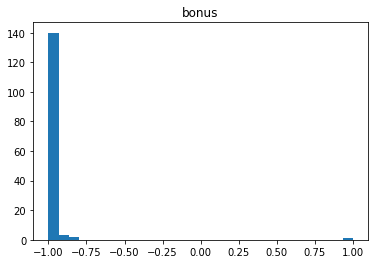

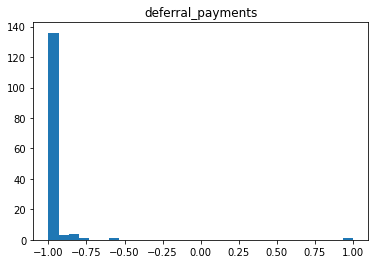

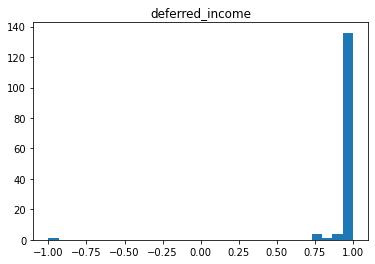

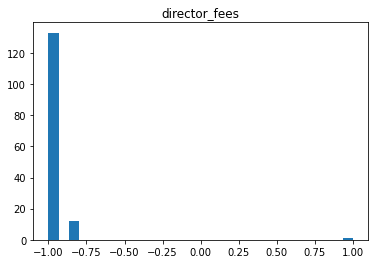

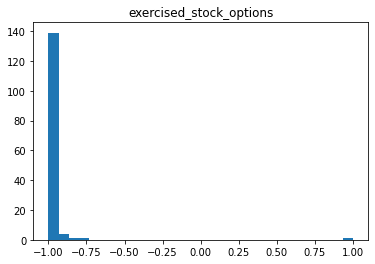

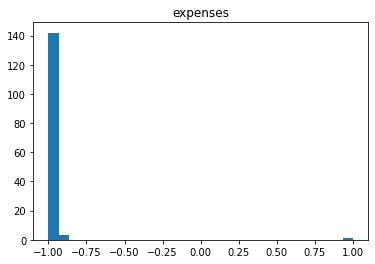

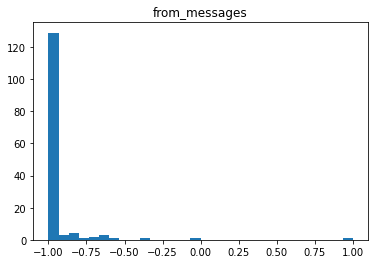

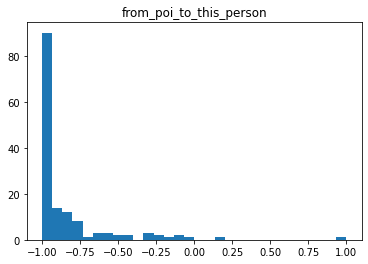

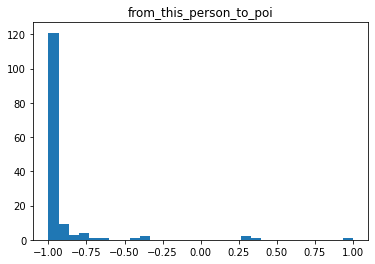

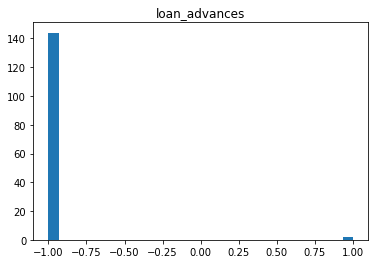

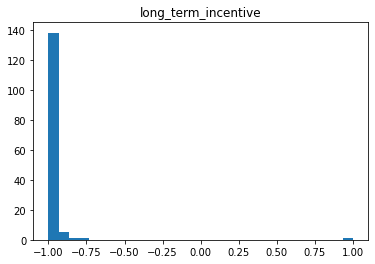

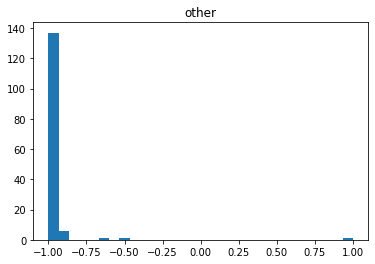

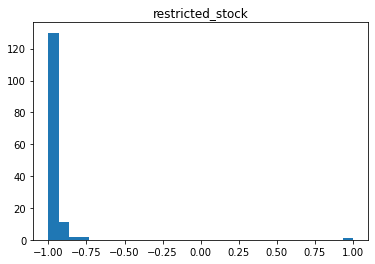

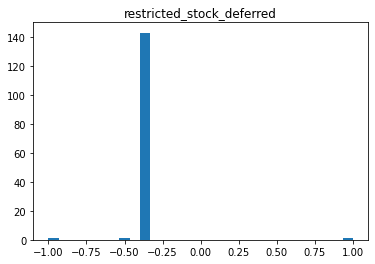

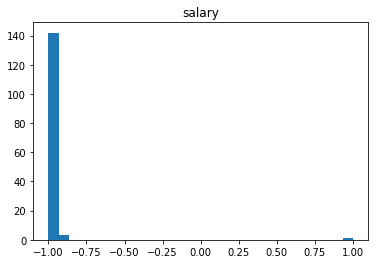

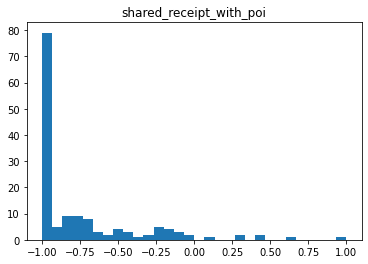

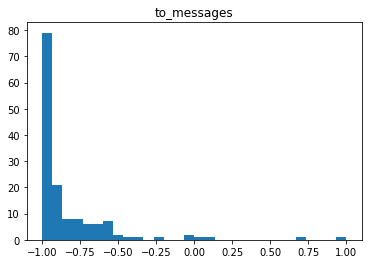

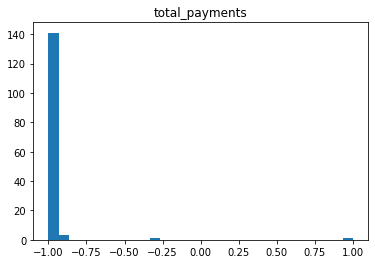

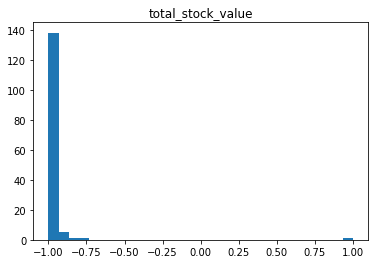

In [74]:
import matplotlib.pyplot as plt
for col in num_features:
    plt.hist(df[col], 30)
    plt.title(col)
    plt.show()

In [75]:
# 將資料最大最小化
df = MinMaxScaler().fit_transform(df)

train_X = df_train
test_X = df_test

# 使用三種模型 : 邏輯斯迴歸 / 梯度提升機 / 隨機森林, 參數使用 Random Search 尋找
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
lr = LogisticRegression(tol=0.001, penalty='l2', fit_intercept=True, C=1.0)
gdbt = GradientBoostingClassifier(tol=100, subsample=0.75, n_estimators=250, max_features=19,
                                  max_depth=6, learning_rate=0.03)
rf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, 
                            max_features='sqrt', max_depth=6, bootstrap=True)





In [76]:
# 線性迴歸預測檔 (結果有部分隨機, 請以 Kaggle 計算的得分為準, 以下模型同理)
lr.fit(train_X, train_Y)
lr_pred = lr.predict_proba(test_X)[:,1]
'''
print ()
print (train_num)


print (test_X.shape)
print (lr_pred.shape)
print (names.shape)
'''

sub = pd.DataFrame({'name': names, 'poi': lr_pred})
sub.to_csv('submit_lr.csv', index=False) 

In [77]:
# 梯度提升機預測檔 
gdbt.fit(train_X, train_Y)
gdbt_pred = gdbt.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': names, 'poi': gdbt_pred})
sub.to_csv('submit_gdbt.csv', index=False) 

In [78]:
# 隨機森林預測檔
rf.fit(train_X, train_Y)
rf_pred = rf.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': names, 'poi': rf_pred})
sub.to_csv('submit_rf.csv', index=False) 

In [79]:

estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=8).mean()



-0.45833333333333337

In [251]:
df_temp

array([[4.09257004e-01, 2.40279096e-01, 0.00000000e+00, ...,
        5.61887092e-02, 1.07944412e-01, 7.33090455e-01],
       [3.16686967e-02, 2.40279096e-01, 9.99107995e-01, ...,
        1.11317254e-02, 4.28384543e-01, 8.23659873e-02],
       [1.77831912e-01, 2.40279096e-01, 8.68261766e-01, ...,
        1.39084385e-01, 5.67077705e-01, 3.34021342e-02],
       ...,
       [2.62469280e-01, 2.40279096e-01, 8.68261766e-01, ...,
        9.46859263e-02, 1.05057782e-02, 1.15910763e-01],
       [2.62469280e-01, 2.40279096e-01, 8.68261766e-01, ...,
        3.41902995e-02, 6.99102455e-05, 7.33976137e-02],
       [1.41291108e-01, 2.40279096e-01, 8.68261766e-01, ...,
        1.00000000e+00, 2.26064506e-01, 3.34660417e-02]])